## Memory Information

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.53GB
Used: 646.20MB
Percentage: 3.9%


## GPU Information

In [2]:
! nvidia-smi

Sat Jul 18 08:25:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Getting the Weights of the Model

In [13]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./depth_estimation/nyu.h5

--2020-07-18 08:33:53--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.24.235
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.24.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./nyu.h5’

./nyu.h5            100%[===================>] 164.89M  28.7MB/s    in 6.5s    

2020-07-18 08:34:00 (25.4 MB/s) - ‘./nyu.h5’ saved [172897376/172897376]



## Linking the Drive to Colab

In [3]:
from google.colab import drive
drive.mount('/content/depth_estimation/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/depth_estimation/gdrive


## Installing Dependencies for the Depth-Model to run

In [4]:
!pip install tensorflow-gpu==1.13.1 --quiet

     |████████████████████████████████| 345.2MB 44kB/s 
     |████████████████████████████████| 3.2MB 34.5MB/s 
     |████████████████████████████████| 368kB 45.8MB/s 
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.


In [5]:
!pip install q keras==2.2.4 --quiet

     |████████████████████████████████| 317kB 4.5MB/s 


In [6]:
!ls

depth_estimation  sample_data


In [7]:
cd depth_estimation

/content/depth_estimation


In [8]:
!ls

augment.py    evaluate.py  layers.py  model_resnet.py  test.py	      utils.py
callbacks.py  gdrive	   loss.py    README.md        test_video.py
data.py       __init__.py  model.py   results.png      train.py


## Creating Model!

In [14]:
import os
import glob
import argparse
import time
from PIL import Image
import numpy as np
import PIL
 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from utils import predict, display_images
from matplotlib import pyplot as plt
 
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
 
print('Loading model...')
 
# Load model into GPU / CPU
model = load_model('nyu.h5', custom_objects=custom_objects, compile=False)

Loading model...
Instructions for updating:
Colocations handled automatically by placer.


## Creating Single and Multiple Images Loading Functions.

In [ ]:
 def load_images_with_resize(image_files):
    loaded_images = []
    for file in image_files:
        im = Image.open(file)
        im = im.resize((640, 480), PIL.Image.ANTIALIAS)
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)
 
def sinlge_load_with_resize(image):
    im = Image.open(image)
    im = im.resize((640, 480), PIL.Image.ANTIALIAS)
    x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
    return x

## Testing 

### Depth Image for Two Example Images and checking their size and type.

my_examples/bg192_21_fg2090.jpg
(240, 320)
(192, 192)
L
my_examples/bg192_00_fg0012.jpg
(240, 320)
(192, 192)
L
my_examples/bg192_59_fg1477.jpg
(240, 320)
(192, 192)
L
--- 7.856898546218872 seconds ---


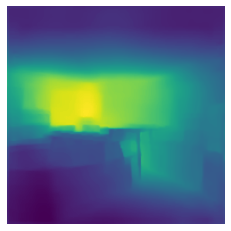

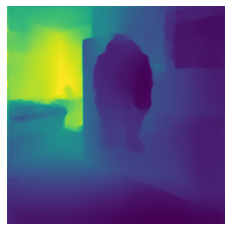

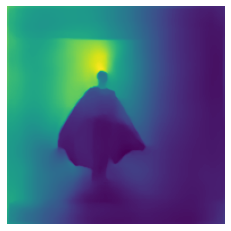

In [ ]:
import timeit
 
start_time = time.time()
for i, filename in enumerate(os.listdir('my_examples')):
  bg_path = os.path.join('my_examples', filename)
  print(bg_path)
  inputs = sinlge_load_with_resize(bg_path)
  outputs = predict(model, inputs)
  outputs = outputs[0][:,:,0]
  outputs = outputs - np.min(outputs)
  outputs = outputs / np.max(outputs)
  cmap = plt.get_cmap('binary_r')
  outputs = cmap(outputs)[:,:,2]
  print(outputs.shape)
  img = Image.fromarray((outputs*255).astype(np.uint8))
  img = img.resize((192,192))
  print(img.size)
  print(img.mode)
  plt.figure()
  plt.axis('off')
  plt.grid('off')
  plt.imshow(img)
  img.save(f'results.jpg')

print("--- %s seconds ---" % (time.time() - start_time))

### Uploading Few Images into Colab and testing to convert to depth and upload as Zip in drive.

In [ ]:
import timeit
from zipfile import ZipFile
from tqdm.auto import tqdm
start_time = time.time()
 
inputs = load_images_with_resize(glob.glob('test/*.jpg'))
print("--- %s Loading seconds ---" % (time.time() - start_time))
start_time2 = time.time()
outputs2 = predict(model, inputs)
print("--- %s Predicting seconds ---" % (time.time() - start_time2))
start_time3 = time.time()
 
with ZipFile('gdrive/My Drive/Pull-0-Depth/test.zip', 'a') as depth_zip:
  for i, filename in tqdm(enumerate(os.listdir('test'))):
    bg_path = os.path.join('test', filename)
    re = outputs2[i][:,:,0]
    re = re - np.min(re)
    re = re / np.max(re)
    cmap = plt.get_cmap('binary_r')
    re = cmap(re)[:,:,0]
    img = Image.fromarray((re*255).astype(np.uint8))
    img = img.resize((192,192))
    img.save('test.jpg')
    depth_zip.write('test.jpg', f'Dataset/depth/{filename[:-4]}.png')
 
  print("--- %s Saving seconds ---" % (time.time() - start_time3))
  print("--- %s Total seconds ---" % (time.time() - start_time))

## Reading the fg_bg Overlay Images directly from Zip!

In [21]:
from zipfile import ZipFile
fg_bg =  ZipFile('gdrive/My Drive/Pull-0-Depth/MonoDepth_Mask_Dataset_192.zip', 'r')
files = [info.filename for info in fg_bg.infolist() if info.filename[8] == 'f']

In [22]:
print('The Number of fg_bg Images: ', len(files))
print('The Last fg_bg Image is: ', files[-1])

The Number of fg_bg Images:  400000
The Last fg_bg Image is:  Dataset/fg_bg/bg192_97_fg3999.jpg


## Function to Read multiple images directly from Zip.

In [16]:
from io import BytesIO

def load_zip_images_with_resize(image_files):
    loaded_images = []
    for file in image_files:
        im = Image.open((BytesIO(fg_bg.read(file))))
        im = im.resize((640, 480), PIL.Image.ANTIALIAS) #Resizing to 640x480.
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

In [37]:
#Checking and Storing for Depth Images in Zip folder if any
from zipfile import ZipFile

test_zip = ZipFile('gdrive/My Drive/Pull-0-Depth/MonoDepth_Mask_Dataset_192.zip', 'r')
depth_files = [info.filename[14:] for info in test_zip.infolist() if info.filename[8] == 'd']
test_zip.close()
if len(depth_files) != 0:
  print(depth_files[-1])
len(depth_files)

bg192_97_fg3999.jpg


400000

# Let's Begin!

In [29]:
img_resize = (192,192)

In [36]:
import timeit
from zipfile import ZipFile
from tqdm.auto import tqdm
 
overall_time = time.time()
 
for i in range(398,400):
  start_time = time.time()
  l = i*1000
  inputs = load_zip_images_with_resize(files[l:l+1000])
  print(f"--- {(time.time() - start_time)} Total seconds for Loading ---")
  outputs2 = predict(model, inputs, batch_size= 5)
  del inputs
  print(f"--- {(time.time() - start_time)} Total seconds for Loading + Predicting ---")
  with ZipFile('gdrive/My Drive/Pull-0-Depth/MonoDepth_Mask_Dataset_192.zip', 'a') as depth_zip:
    for j,filename in enumerate(files[l:l+1000]):
      if filename[14:] in depth_files: #If Same File Exists Skip the File.
        print(f'Depth Image {filename[14:]} Already Create, Skipping!')
        continue
      re = outputs2[j][:,:,0]
      re = re - np.min(re)
      re = re / np.max(re)
      cmap = plt.get_cmap('binary_r') #Converting to Gray Scale Depth
      re = cmap(re)[:,:,0] #Single Channel
      img = Image.fromarray((re*255).astype(np.uint8))
      img = img.resize(img_resize)
      img.save('test.jpg')
      depth_zip.write('test.jpg', f'Dataset/depth/{filename[14:-4]}.jpg')
 
  print(f"--- {(time.time() - start_time)} Total seconds for Batch No: {i} ---")
  print('**********************************************************************')
test_zip = ZipFile('gdrive/My Drive/Pull-0-Depth/MonoDepth_Mask_Dataset_192.zip', 'r')
depth_files = [info.filename[14:] for info in test_zip.infolist() if info.filename[8] == 'd']
test_zip.close()
print('The Last Depth File is: ', depth_files[-1])
print('The Number of Depth Files are: ', len(depth_files))
print(f"--- {(time.time() - overall_time)} Total seconds ---")

--- 15.387519836425781 Total seconds for Loading ---
--- 56.93690514564514 Total seconds for Loading + Predicting ---
--- 147.51696681976318 Total seconds for Batch No: 398 ---
**********************************************************************
--- 18.869320392608643 Total seconds for Loading ---
--- 60.78732466697693 Total seconds for Loading + Predicting ---
--- 88.83359408378601 Total seconds for Batch No: 399 ---
**********************************************************************
The Last Depth File is:  bg192_97_fg3999.jpg
The Number of Depth Files are:  400000
--- 249.44324707984924 Total seconds ---
